In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PathologyCore — Day 1: U-Net Nuclear Segmentation (Kaggle)
**What this notebook contains**
- U-Net implemented from scratch (encoder/decoder, skip connections)
- Dice and BCE+Dice loss implementations
- Data loader for PanNuke-style patches
- Training loop with AMP & gradient accumulation (Kaggle-friendly)
- Demo inference + visualization

**Dataset**
- PanNuke: Pan-cancer nuclei instance segmentation + classification dataset. Official project and download info: PanNuke dataset page and dataset extension paper. :contentReference[oaicite:3]{index=3}
- Kaggle mirrors are available for quick testing (search "pannuke"). :contentReference[oaicite:4]{index=4}

**Notes**
- Set `DATA_DIR` to your Kaggle dataset mount (e.g., `/kaggle/input/pannuke/`).
- Use GPU runtime; this notebook uses mixed precision and accumulation to work with small GPU memory.


In [2]:
# basic imports
import os
import random
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF

# skimage / cv2 for postprocessing and visualization
from skimage import measure, morphology
import cv2

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# Configs & Kaggle paths (Code)

In [3]:
import os

DATA_DIR = "/kaggle/input/pannuke-dataset-experimental-data"

print("Top level:", os.listdir(DATA_DIR))
print("Train subfolders:", os.listdir(os.path.join(DATA_DIR, "train")))
print("Validate subfolders:", os.listdir(os.path.join(DATA_DIR, "validate")))


Top level: ['validate', 'model.h5', 'train']
Train subfolders: ['images', 'masks']
Validate subfolders: ['images', 'masks']


In [4]:
train_imgs = os.listdir(os.path.join(DATA_DIR, "train/images"))
train_masks = os.listdir(os.path.join(DATA_DIR, "train/masks"))

val_imgs = os.listdir(os.path.join(DATA_DIR, "validate/images"))
val_masks = os.listdir(os.path.join(DATA_DIR, "validate/masks"))

print("Train images:", len(train_imgs), "Train masks:", len(train_masks))
print("Val images:", len(val_imgs), "Val masks:", len(val_masks))


Train images: 6716 Train masks: 6716
Val images: 1185 Val masks: 1185


In [ ]:
import cv2
import matplotlib.pyplot as plt

# pick one image and mask
img_path = os.path.join(DATA_DIR, "train/images", train_imgs[1])
mask_path = os.path.join(DATA_DIR, "train/masks", train_masks[1])

# read
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# show
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Histology Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()


# Configs & Kaggle paths (Code)

In [6]:
# === CONFIG ===
DATA_DIR = "/kaggle/input/pannuke-dataset-experimental-data"
OUT_DIR = "/kaggle/working"          # Kaggle working dir
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# training hyperparams (Kaggle-friendly)
PATCH_SIZE = 256     # 512 if memopry persista s
BATCH_SIZE = 4      
EPOCHS = 25
LR = 1e-3
ACCUM_STEPS = 2 


# Find images & sanity check

Train images: 6716, Train masks: 6716
Val images: 1185, Val masks: 1185


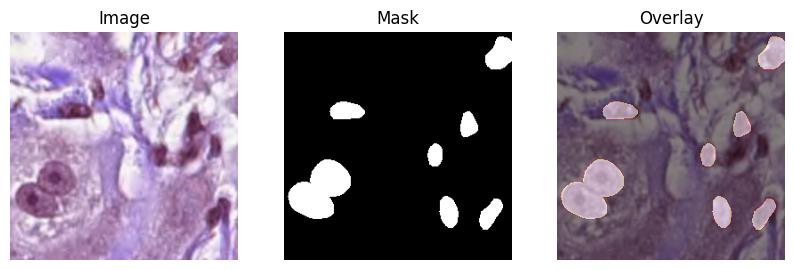

In [7]:
# Cell 5 — sanity check for Pannuke dataset
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt

DATA_DIR = "/kaggle/input/pannuke-dataset-experimental-data"

# train/validate folders
train_imgs = sorted(glob(os.path.join(DATA_DIR, "train/images/*")))
train_masks = sorted(glob(os.path.join(DATA_DIR, "train/masks/*")))
val_imgs = sorted(glob(os.path.join(DATA_DIR, "validate/images/*")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "validate/masks/*")))


print(f"Train images: {len(train_imgs)}, Train masks: {len(train_masks)}")
print(f"Val images: {len(val_imgs)}, Val masks: {len(val_masks)}")

# Show first sample pair
img = cv2.cvtColor(cv2.imread(train_imgs[0]), cv2.COLOR_BGR2RGB)
mask = cv2.imread(train_masks[0], cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(mask>127, alpha=0.5, cmap="hot"); plt.title("Overlay"); plt.axis("off")
plt.show()


# Dataset class

In [8]:
import numpy as np
from torch.utils.data import Dataset

class PannukeSegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, patch_size=256, transform=None):
        self.imgs = img_paths
        self.masks = mask_paths
        assert len(self.imgs) == len(self.masks), "Images and masks count mismatch"
        self.ps = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.imgs[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('uint8')

        if img.shape[0] != self.ps or img.shape[1] != self.ps:
            img = cv2.resize(img, (self.ps, self.ps), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (self.ps, self.ps), interpolation=cv2.INTER_NEAREST)

        img = img.astype('float32') / 255.0
        img = np.transpose(img, (2,0,1))   # C,H,W
        mask = mask[None,:,:].astype('float32')

        return torch.tensor(img), torch.tensor(mask)


# Sample Dataset Creation

In [9]:
import os, shutil, random
from glob import glob
import cv2

DATA_DIR = "/kaggle/input/pannuke-dataset-experimental-data"
OUT_DIR = "/kaggle/working/pannuke_sample"
SAMPLE_TRAIN = 500
SAMPLE_VAL = 100
PATCH_SIZE = 256   # resize to this (set None to keep original)
SEED = 42

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "train/images"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "train/masks"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "validate/images"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "validate/masks"), exist_ok=True)

# list original
train_imgs_full = sorted(glob(os.path.join(DATA_DIR, "train/images/*")))
train_masks_full = sorted(glob(os.path.join(DATA_DIR, "train/masks/*")))
val_imgs_full = sorted(glob(os.path.join(DATA_DIR, "validate/images/*")))
val_masks_full = sorted(glob(os.path.join(DATA_DIR, "validate/masks/*")))

# sample reproducibly
rng = random.Random(SEED)
train_indices = list(range(len(train_imgs_full))); rng.shuffle(train_indices); train_indices = train_indices[:min(SAMPLE_TRAIN, len(train_indices))]
val_indices = list(range(len(val_imgs_full))); rng.shuffle(val_indices); val_indices = val_indices[:min(SAMPLE_VAL, len(val_indices))]

def copy_and_resize(src_path, dst_path, size=None, is_mask=False):
    if size is None:
        shutil.copy2(src_path, dst_path)
        return
    # read and resize
    if is_mask:
        im = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (size, size), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(dst_path, im)
    else:
        im = cv2.cvtColor(cv2.imread(src_path), cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
        # save as RGB->BGR for cv2.imwrite
        cv2.imwrite(dst_path, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

# copy train samples
for i, idx in enumerate(train_indices):
    s_img = train_imgs_full[idx]
    s_mask = train_masks_full[idx]
    dst_img = os.path.join(OUT_DIR, "train/images", f"img_{i:04d}.png")
    dst_mask = os.path.join(OUT_DIR, "train/masks", f"mask_{i:04d}.png")
    copy_and_resize(s_img, dst_img, size=PATCH_SIZE, is_mask=False)
    copy_and_resize(s_mask, dst_mask, size=PATCH_SIZE, is_mask=True)

# copy val samples
for i, idx in enumerate(val_indices):
    s_img = val_imgs_full[idx]
    s_mask = val_masks_full[idx]
    dst_img = os.path.join(OUT_DIR, "validate/images", f"img_{i:04d}.png")
    dst_mask = os.path.join(OUT_DIR, "validate/masks", f"mask_{i:04d}.png")
    copy_and_resize(s_img, dst_img, size=PATCH_SIZE, is_mask=False)
    copy_and_resize(s_mask, dst_mask, size=PATCH_SIZE, is_mask=True)

print("Sample dataset prepared at:", OUT_DIR)
print("Train images:", len(os.listdir(os.path.join(OUT_DIR, "train/images"))))
print("Train masks:", len(os.listdir(os.path.join(OUT_DIR, "train/masks"))))
print("Val images:", len(os.listdir(os.path.join(OUT_DIR, "validate/images"))))
print("Val masks:", len(os.listdir(os.path.join(OUT_DIR, "validate/masks"))))


Sample dataset prepared at: /kaggle/working/pannuke_sample
Train images: 500
Train masks: 500
Val images: 100
Val masks: 100


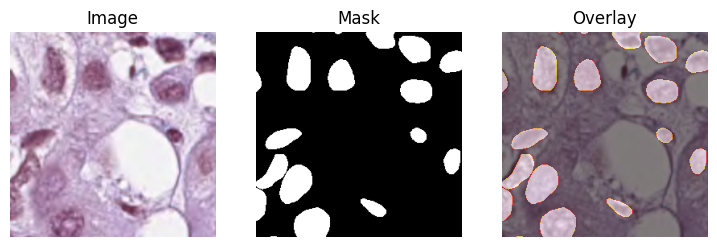

In [10]:
import matplotlib.pyplot as plt
import cv2

# show first sample from train
sample_img = sample_train_imgs[0] if 'sample_train_imgs' in globals() else sorted(glob(os.path.join(OUT_DIR,"train/images/*")))[0]
sample_mask = sample_train_masks[0] if 'sample_train_masks' in globals() else sorted(glob(os.path.join(OUT_DIR,"train/masks/*")))[0]
img = cv2.cvtColor(cv2.imread(sample_img), cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample_mask, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img); plt.axis('off'); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(mask>127, alpha=0.5, cmap='hot'); plt.axis('off'); plt.title("Overlay")
plt.show()


In [11]:
# sample_train_imgs = sorted(glob(os.path.join(OUT_DIR, "train/images/*")))
# sample_train_masks = sorted(glob(os.path.join(OUT_DIR, "train/masks/*")))
# sample_val_imgs = sorted(glob(os.path.join(OUT_DIR, "validate/images/*")))
# sample_val_masks = sorted(glob(os.path.join(OUT_DIR, "validate/masks/*")))

# train_ds = PannukeSegDataset(sample_train_imgs, sample_train_masks, patch_size=PATCH_SIZE)
# val_ds = PannukeSegDataset(sample_val_imgs, sample_val_masks, patch_size=PATCH_SIZE)

# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


# Actual DataLoaders (Will run after Completion)

In [12]:
from torch.utils.data import DataLoader

train_ds = PannukeSegDataset(train_imgs, train_masks, patch_size=256)
val_ds   = PannukeSegDataset(val_imgs, val_masks, patch_size=256)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 1679 Val batches: 297


# U-Net Implementation

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY, diffX = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, base=32):
        super().__init__()
        self.inc   = DoubleConv(n_channels, base)
        self.down1 = Down(base, base*2)
        self.down2 = Down(base*2, base*4)
        self.down3 = Down(base*4, base*8)
        self.down4 = Down(base*8, base*8)
        self.up1   = Up(base*16, base*4)
        self.up2   = Up(base*8, base*2)
        self.up3   = Up(base*4, base)
        self.up4   = Up(base*2, base)
        self.outc  = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)


# Loss functions

In [14]:
def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(pred.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)
    inter = (pred * target).sum(1)
    union = pred.sum(1) + target.sum(1)
    return ((2. * inter + eps) / (union + eps)).mean()

class DiceLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        return 1 - dice_coeff(probs, targets)

class BCEDiceLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.dice = DiceLoss()
    def forward(self, logits, targets):
        return self.alpha * self.bce(logits, targets) + (1-self.alpha) * self.dice(logits, targets)


# Training loop

In [16]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = BCEDiceLoss()

best_val = 0.0
EPOCHS = 5

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    with torch.no_grad():
        dices = []
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            probs = torch.sigmoid(model(imgs))
            dice = dice_coeff(probs, masks)
            dices.append(dice.item())
    val_dice = sum(dices)/len(dices)
    print(f"Epoch {epoch}: Train loss {avg_loss:.4f}, Val Dice {val_dice:.4f}")

    if val_dice > best_val:
        best_val = val_dice
        torch.save(model.state_dict(), "unet_best.pth")
        print("✅ Saved best model")


Epoch 1/5: 100%|██████████| 1679/1679 [01:02<00:00, 26.96it/s]


Epoch 1: Train loss 0.3140, Val Dice 0.6533
✅ Saved best model


Epoch 2/5: 100%|██████████| 1679/1679 [01:02<00:00, 27.06it/s]


Epoch 2: Train loss 0.2720, Val Dice 0.6787
✅ Saved best model


Epoch 3/5: 100%|██████████| 1679/1679 [01:02<00:00, 27.07it/s]


Epoch 3: Train loss 0.2373, Val Dice 0.7029
✅ Saved best model


Epoch 4/5: 100%|██████████| 1679/1679 [01:02<00:00, 27.06it/s]


Epoch 4: Train loss 0.2162, Val Dice 0.7327
✅ Saved best model


Epoch 5/5: 100%|██████████| 1679/1679 [01:01<00:00, 27.09it/s]


Epoch 5: Train loss 0.2070, Val Dice 0.7431
✅ Saved best model


# Inference & Visualization

In [ ]:
# load best model
model.load_state_dict(torch.load("unet_best.pth", map_location=device))
model.eval()

# visualize a few validation predictions
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad():
    logits = model(imgs)
    preds = torch.sigmoid(logits).cpu().numpy()

for i in range(min(3, imgs.shape[0])):
    img = imgs[i].cpu().numpy().transpose(1,2,0)
    mask = masks[i][0].cpu().numpy()
    pred = preds[i][0]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img); plt.imshow(pred>0.5, alpha=0.5, cmap="hot"); plt.title("Prediction"); plt.axis("off")
    plt.show()


# PathologyCore — Day 2: Nucleus Classification & High-Resolution Patch Pipeline

What this notebook does:
- Extract nucleus instance patches from segmentation masks (use UNet predictions or instance masks).
- Prepare a region-level dataset for multi-class classification (auto-detect PanNuke label files if available).
- Train a small CNN classifier on nucleus patches (multi-class).
- Provide a sliding-window high-resolution inference pipeline:
    1. segment large image with U-Net (patch-based),
    2. extract instances,
    3. classify each nucleus patch,
    4. output per-nucleus class + quantification CSV.

Paths:
- Dataset: /kaggle/input/pannuke-dataset-experimental-data
- Checkpoint (segmentation): /kaggle/working/unet_best.pth (or use your trained model)


In [ ]:
# Cell 2 — imports & config
import os, sys, math, json, shutil
from glob import glob
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Paths (adjust if needed)
DATA_DIR = "/kaggle/input/pannuke-dataset-experimental-data"
SEG_CHECKPOINT = "/kaggle/working/unet_best.pth"  # path where you saved day1 model
OUT_DIR = "/kaggle/working/day2_results"
PATCH_OUT = os.path.join(OUT_DIR, "nucleus_patches")
os.makedirs(PATCH_OUT, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


# Attempt to locate class labels (auto-detect)

In [ ]:
# Cell 3 — try to find PanNuke class annotations (CSV/json) or instance masks
# PanNuke variants sometimes include CSV with instance/class info or separate folders with 'inst' or 'instance'
candidates = sorted(os.listdir(DATA_DIR))
print("Top-level:", candidates)

# common patterns
labels_csv = None
for fname in ["labels.csv", "annotations.csv", "instances.csv", "pannuke_labels.csv"]:
    p = os.path.join(DATA_DIR, fname)
    if os.path.exists(p):
        labels_csv = p
        break

# Also scan train/validate subfolders for annotation files
if labels_csv is None:
    for root in [os.path.join(DATA_DIR, d) for d in ["train","validate"] if os.path.isdir(os.path.join(DATA_DIR,d))]:
        for fname in os.listdir(root):
            if fname.lower().endswith(".csv"):
                labels_csv = os.path.join(root, fname)
                break
        if labels_csv:
            break

print("Detected labels csv:", labels_csv)

# scan for instance mask folders (pixel-wise instances rather than binary)
inst_masks_paths = []
for sub in ["train","validate"]:
    inst_dir = os.path.join(DATA_DIR, sub, "instances")
    if os.path.isdir(inst_dir):
        inst_masks_paths.append(inst_dir)
# also try folder name containing 'inst' anywhere
for root, dirs, files in os.walk(DATA_DIR):
    for d in dirs:
        if "inst" in d.lower():
            inst_masks_paths.append(os.path.join(root, d))
inst_masks_paths = list(sorted(set(inst_masks_paths)))
print("Detected instance mask folders (heuristic):", inst_masks_paths)


# Load segmentation model

In [ ]:
# Cell 4 — load UNet (same implementation as Day1)
# Paste the UNet / DoubleConv / Down / Up classes from Day1 here or import from your package
# For brevity, define a lightweight UNet builder function that matches Day1 model

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY, diffX = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

class UNetLite(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, base=32):
        super().__init__()
        self.inc   = DoubleConv(n_channels, base)
        self.down1 = Down(base, base*2)
        self.down2 = Down(base*2, base*4)
        self.down3 = Down(base*4, base*8)
        self.down4 = Down(base*8, base*8)
        self.up1   = Up(base*16, base*4)
        self.up2   = Up(base*8, base*2)
        self.up3   = Up(base*4, base)
        self.up4   = Up(base*2, base)
        self.outc  = nn.Conv2d(base, n_classes, 1)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1)
        return self.outc(x)

# instantiate and load checkpoint if available
seg_model = UNetLite(n_channels=3, n_classes=1, base=32).to(DEVICE)
if os.path.exists(SEG_CHECKPOINT):
    ck = torch.load(SEG_CHECKPOINT, map_location=DEVICE)
    # ck may be a state_dict or a checkpoint dict
    if "model_state_dict" in ck:
        seg_model.load_state_dict(ck["model_state_dict"])
    else:
        seg_model.load_state_dict(ck)
    print("Loaded segmentation checkpoint:", SEG_CHECKPOINT)
else:
    print("Segmentation checkpoint not found at", SEG_CHECKPOINT, "— run Day1 train or set correct path.")
seg_model.eval()


# Instance extraction util: from binary mask → instances (watershed)

In [ ]:
# Cell 5 — instance extraction (watershed) and helper to crop nucleus patch
import skimage.morphology as morph
from skimage import measure

def mask_to_instances(binary_mask, min_size=20):
    """Convert binary_mask (H,W uint8 {0,1}) into instance labels using watershed / distance transform."""
    # remove small objects
    cleaned = morph.remove_small_objects(binary_mask.astype(bool), min_size=min_size)
    cleaned = cleaned.astype(np.uint8)
    if cleaned.sum() == 0:
        return np.zeros_like(binary_mask, dtype=np.int32)
    dist = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
    # detect local maxima (simple)

    local_max = (dist == cv2.dilate(dist, np.ones((3,3))))
    markers = measure.label(local_max)
    # NOTE: use skimage watershed
    from skimage.segmentation import watershed
    labels = watershed(-dist, markers, mask=cleaned)
    return labels  # integer-labelled image, 0 = background

def extract_instances_from_prediction(img_rgb, pred_probs, min_size=20, pad=8):
    """
    Input:
      img_rgb: HxW x 3 (uint8 or float 0..1)
      pred_probs: HxW float (0..1)
    Returns:
      list of dicts: {'label': id, 'bbox':(y1,x1,y2,x2), 'crop': HxW patch (RGB), 'mask': instance mask in crop}
    """
    binmask = (pred_probs > 0.5).astype(np.uint8)
    labels = mask_to_instances(binmask, min_size=min_size)
    props = measure.regionprops(labels)
    results = []
    H,W = labels.shape
    for prop in props:
        y0, x0, y1, x1 = prop.bbox  # (min_row, min_col, max_row, max_col)
        # expand bbox by pad but keep inside image
        y0e, x0e = max(0, y0-pad), max(0, x0-pad)
        y1e, x1e = min(H, y1+pad), min(W, x1+pad)
        crop = img_rgb[y0e:y1e, x0e:x1e].copy()
        # instance mask cropped and binarized
        inst_mask_crop = (labels[y0e:y1e, x0e:x1e] == prop.label).astype(np.uint8)
        results.append({
            "label": int(prop.label),
            "bbox": (y0e, x0e, y1e, x1e),
            "crop": crop,
            "mask": inst_mask_crop
        })
    return results


# Generate nucleus patches from dataset using segmentation model

In [ ]:
# Cell 6 — run segmentation model on validation images (or train images) and save nucleus patches
# We'll produce a CSV mapping: patch_path, source_image, instance_id, y0,x0,y1,x1
save_csv_rows = []
patch_counter = 0

# choose images to run segmentation on (use train or validate as needed)
IMAGE_LIST = sorted(glob(os.path.join(DATA_DIR, "train/images/*")))  # use train images to create train patches
print("Num images to process for patch extraction:", len(IMAGE_LIST))

# helper to run model on patch (model expects 3xHxW float tensors)
def seg_predict_on_image(img_bgr, model, patch_size=256, stride=256):
    # Single-image sliding window inference (no overlap for speed). Returns prob map HxW float.
    H,W,_ = img_bgr.shape
    prob_map = np.zeros((H,W), dtype=np.float32)
    count_map = np.zeros((H,W), dtype=np.float32)
    for y in range(0, max(1, H - patch_size + 1), stride):
        for x in range(0, max(1, W - patch_size + 1), stride):
            crop = img_bgr[y:y+patch_size, x:x+patch_size]
            if crop.shape[0] != patch_size or crop.shape[1] != patch_size:
                pad = np.zeros((patch_size, patch_size, 3), dtype=crop.dtype)
                pad[:crop.shape[0], :crop.shape[1]] = crop
                crop = pad
            inp = torch.tensor(crop.astype(np.float32)/255.).permute(2,0,1).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = model(inp)
                probs = torch.sigmoid(logits).cpu().numpy()[0,0]
            prob_map[y:y+patch_size, x:x+patch_size] += probs[:crop.shape[0], :crop.shape[1]]
            count_map[y:y+patch_size, x:x+patch_size] += 1.0
    # avoid division by zero
    count_map[count_map == 0] = 1.0
    prob_map = prob_map / count_map
    return prob_map

for img_path in tqdm(IMAGE_LIST[:200]):  # limit to first 200 for speed; adjust as needed
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    prob_map = seg_predict_on_image(img_bgr, seg_model, patch_size=256, stride=224)
    instances = extract_instances_from_prediction(img_rgb, prob_map, min_size=20, pad=8)
    for inst in instances:
        crop = inst["crop"]
        # save crop as patch (convert RGB to PNG)
        patch_name = f"patch_{patch_counter:06d}.png"
        patch_path = os.path.join(PATCH_OUT, patch_name)
        cv2.imwrite(patch_path, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
        save_csv_rows.append({
            "patch_path": patch_path,
            "source_image": os.path.basename(img_path),
            "instance_id": inst["label"],
            "bbox": inst["bbox"]
        })
        patch_counter += 1

print("Saved patches:", patch_counter)
df_patches = pd.DataFrame(save_csv_rows)
csv_patches = os.path.join(OUT_DIR, "extracted_patches_train.csv")
df_patches.to_csv(csv_patches, index=False)
print("Patch CSV:", csv_patches)


# Try to match patches to class labels (if PanNuke instance/class annotations exist)

In [ ]:
# Cell 7 — attempt to attach class labels for each extracted instance using PanNuke labels CSV if available
label_map = None
if labels_csv and os.path.exists(labels_csv):
    print("Loading labels CSV:", labels_csv)
    df_labels = pd.read_csv(labels_csv)
    # Expected format (heuristic): columns like ['image','instance','class']
    print("Labels CSV columns:", df_labels.columns.tolist())
    # Try to normalize column names
    columns = [c.lower() for c in df_labels.columns]
    # Find likely columns
    find_image_col = None
    find_inst_col = None
    find_class_col = None
    for c_orig, c in zip(df_labels.columns, columns):
        if "image" in c or "img" in c or "filename" in c:
            find_image_col = c_orig
        if "inst" in c or "instance" in c or "id" in c and "inst" in c:
            find_inst_col = c_orig
        if "class" in c or "label" in c and "class" not in c:
            find_class_col = c_orig
    print("Detected columns:", find_image_col, find_inst_col, find_class_col)
    # If the exact instance mapping doesn't exist, we will fallback
    if find_image_col and find_class_col:
        # create dictionary: (image, instance_id) -> class
        mapping = {}
        for _, row in df_labels.iterrows():
            imgname = os.path.basename(str(row[find_image_col]))
            inst = row[find_inst_col] if find_inst_col in df_labels.columns else None
            cls = row[find_class_col]
            mapping[(imgname, int(inst) if pd.notna(inst) else None)] = cls
        # now attach class if mapping found
        df_patches["class"] = None
        for i, r in df_patches.iterrows():
            key = (r["source_image"], r["instance_id"])
            cls = mapping.get(key, None)
            df_patches.at[i,"class"] = cls
        # show counts
        print("Class value counts (attached):")
        print(df_patches["class"].value_counts(dropna=False))
        df_patches.to_csv(os.path.join(OUT_DIR,"extracted_patches_train_with_classes.csv"), index=False)
    else:
        print("Labels CSV present but couldn't find suitable columns for mapping. Will save patches; you can map labels later.")
else:
    print("No labels CSV found. You can label the extracted patches in a tool (or use PanNuke original mapping).")
    df_patches.to_csv(os.path.join(OUT_DIR,"extracted_patches_train_no_labels.csv"), index=False)

print("Patches CSV saved. Inspect:", os.listdir(PATCH_OUT)[:10])


# Dataset class for patch-level classification

In [ ]:
# Cell 8 — create a classification dataset that reads saved patches CSV and provides (image, label) pairs
class NucleusPatchDataset(Dataset):
    def __init__(self, patches_csv, transform=None, target_transform=None):
        self.df = pd.read_csv(patches_csv)
        # ensure there is a class column; if not, we will set dummy -1
        if "class" not in self.df.columns:
            self.df["class"] = -1
        # map classes to int labels if needed
        unique_classes = [c for c in self.df["class"].unique() if pd.notna(c) and c != -1]
        self.class_to_idx = {c:i for i,c in enumerate(sorted(unique_classes))}
        # if no classes (all -1), classifier can't be trained — but dataloader still prepared
        self.df["label_idx"] = self.df["class"].apply(lambda x: self.class_to_idx.get(x, -1))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row["patch_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # resize to classifier input
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2,0,1))
        label = int(row["label_idx"])
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# create dataset if CSV exists
patch_csv_path = os.path.join(OUT_DIR,"extracted_patches_train_with_classes.csv")
if not os.path.exists(patch_csv_path):
    # fallback to no-label CSV
    patch_csv_path = os.path.join(OUT_DIR,"extracted_patches_train_no_labels.csv")

cls_dataset = NucleusPatchDataset(patch_csv_path)
print("Total patches:", len(cls_dataset), "num_classes:", len(cls_dataset.class_to_idx))


# Small CNN classifier model

In [ ]:
# Cell 9 — define a small classification CNN (simple ResNet-lite)
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# create model only if there are classes (>0)
n_classes = max(1, len(cls_dataset.class_to_idx))  # avoid 0
if len(cls_dataset.class_to_idx) == 0:
    print("No labeled classes detected. Classifier will not be trained until labels are present.")
classifier = SimpleCNN(n_classes).to(DEVICE)
print("Classifier created. n_classes =", n_classes)


# DataLoaders for classifier

In [ ]:
# Cell 10 — dataloaders
# Split dataset into train/val (if labelled)
if len(cls_dataset) == 0:
    raise RuntimeError("No patches found. Run patch extraction cell (Cell 6).")

# indices for labeled samples (label_idx != -1)
labels_present = cls_dataset.df["label_idx"] != -1
if labels_present.sum() == 0:
    print("No labeled samples yet (all label_idx == -1). Save patches and label them, then rerun this cell.")
else:
    labeled_df = cls_dataset.df[labels_present].reset_index(drop=True)
    # simple split
    n = len(labeled_df)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    s = int(0.8 * n)
    train_idxs, val_idxs = idxs[:s], idxs[s:]
    # create subset datasets
    from torch.utils.data import Subset
    class LabelledPatchDataset(NucleusPatchDataset):
        def __init__(self, base_csv, indices):
            super().__init__(base_csv)
            self.indices = indices
        def __len__(self): return len(self.indices)
        def __getitem__(self, idx):
            return super().__getitem__(self.indices[idx])

    train_dataset = LabelledPatchDataset(patch_csv_path, train_idxs)
    val_dataset   = LabelledPatchDataset(patch_csv_path, val_idxs)
    train_loader_cls = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    val_loader_cls   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    print("Classifier train/val sizes:", len(train_dataset), len(val_dataset))


# Training loop for classifier

In [ ]:
# Cell 11 — classifier training (if labeled data exist)
if labels_present.sum() == 0:
    print("Skipping training as no labeled samples detected. Label patches in CSV then rerun.")
else:
    clf_device = DEVICE
    classifier.to(clf_device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-5)
    # compute class weights
    label_counts = Counter(train_dataset.df.loc[train_dataset.indices, "label_idx"])
    counts = [label_counts.get(i,0) for i in range(len(cls_dataset.class_to_idx))]
    total = sum(counts)
    class_weights = torch.tensor([total/(c+1e-8) for c in counts], dtype=torch.float32).to(clf_device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_acc = 0.0
    EPOCHS_CLS = 12
    for epoch in range(1, EPOCHS_CLS+1):
        classifier.train()
        running_loss = 0.0
        correct = 0; seen = 0
        for imgs, labels in train_loader_cls:
            imgs = imgs.to(clf_device); labels = labels.to(clf_device)
            logits = classifier(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            seen += imgs.size(0)
        train_loss = running_loss / seen
        train_acc = correct / seen

        # validation
        classifier.eval()
        correct = 0; seen = 0
        with torch.no_grad():
            for imgs, labels in val_loader_cls:
                imgs = imgs.to(clf_device); labels = labels.to(clf_device)
                logits = classifier(imgs)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                seen += imgs.size(0)
        val_acc = correct / seen
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Train acc {train_acc:.3f}, Val acc {val_acc:.3f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(classifier.state_dict(), os.path.join(OUT_DIR, "classifier_best.pth"))
            print("Saved classifier checkpoint.")


# Evaluation metrics for classification

In [ ]:
# Cell 12 — compute precision/recall/f1 per class on validation set
from sklearn.metrics import classification_report, confusion_matrix

if labels_present.sum() == 0:
    print("No labels: cannot compute classification metrics.")
else:
    # load best classifier
    classifier.load_state_dict(torch.load(os.path.join(OUT_DIR, "classifier_best.pth"), map_location=DEVICE))
    classifier.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for imgs, labels in val_loader_cls:
            imgs = imgs.to(DEVICE)
            logits = classifier(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_trues.extend(labels.numpy().tolist())
    print(classification_report(all_trues, all_preds, zero_division=0))
    cm = confusion_matrix(all_trues, all_preds)
    print("Confusion matrix:\n", cm)


# High-resolution pipeline: segment a large image then classify per-nucleus

In [ ]:
# sliding-window segmentation + instance classification for a large image
# choose a sample large image from validate images
sample_img_path = sorted(glob(os.path.join(DATA_DIR, "validate/images/*")))[0]
print("Using sample:", sample_img_path)
orig_bgr = cv2.imread(sample_img_path)
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

# segmentation (use seg_predict_on_image from Day2 Cell 6; reimplement small version with overlap)
def sliding_seg_predict(img_bgr, model, patch_size=256, stride=192):
    H,W,_ = img_bgr.shape
    prob_map = np.zeros((H,W), dtype=np.float32)
    count_map = np.zeros((H,W), dtype=np.float32)
    for y in range(0, H, stride):
        for x in range(0, W, stride):
            y1 = y; x1 = x; y2 = min(y1+patch_size, H); x2 = min(x1+patch_size, W)
            crop = img_bgr[y1:y2, x1:x2]
            pad_h = patch_size - crop.shape[0]; pad_w = patch_size - crop.shape[1]
            if pad_h or pad_w:
                crop_p = np.zeros((patch_size, patch_size, 3), dtype=crop.dtype)
                crop_p[:crop.shape[0], :crop.shape[1]] = crop
                crop = crop_p
            inp = torch.tensor(crop.astype(np.float32)/255.).permute(2,0,1).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = model(inp)
                probs = torch.sigmoid(logits).cpu().numpy()[0,0]
            probs = probs[:y2-y1, :x2-x1]
            prob_map[y1:y2, x1:x2] += probs
            count_map[y1:y2, x1:x2] += 1.0
    count_map[count_map==0] = 1.0
    prob_map = prob_map / count_map
    return prob_map

print("Running segmentation on sample image...")
prob_map = sliding_seg_predict(orig_bgr, seg_model, patch_size=256, stride=192)
binmask = (prob_map > 0.5).astype(np.uint8)
labels = mask_to_instances(binmask, min_size=20)

# classify each instance using trained classifier (if available)
instances = measure.regionprops(labels)
results = []
if os.path.exists(os.path.join(OUT_DIR,"classifier_best.pth")):
    classifier.load_state_dict(torch.load(os.path.join(OUT_DIR,"classifier_best.pth"), map_location=DEVICE))
    classifier.eval()
    for prop in instances:
        y0,x0,y1,x1 = prop.bbox
        pad = 8
        y0e, x0e = max(0, y0-pad), max(0, x0-pad)
        y1e, x1e = min(labels.shape[0], y1+pad), min(labels.shape[1], x1+pad)
        crop = orig_rgb[y0e:y1e, x0e:x1e]
        crop_resized = cv2.resize(crop, (64,64))
        inp = torch.tensor(crop_resized.astype(np.float32)/255.).permute(2,0,1).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = classifier(inp)
            pred = logits.argmax(dim=1).item()
        results.append({
            "instance_id": prop.label,
            "bbox": (y0e,x0e,y1e,x1e),
            "class_pred": pred
        })
else:
    # no classifier — just return instances (class_pred = -1)
    for prop in instances:
        y0,x0,y1,x1 = prop.bbox
        results.append({
            "instance_id": prop.label,
            "bbox": (y0,x0,y1,x1),
            "class_pred": -1
        })

# save CSV
out_csv = os.path.join(OUT_DIR, "sample_image_nuclei_classification.csv")
pd.DataFrame(results).to_csv(out_csv, index=False)
print("Saved per-nucleus CSV:", out_csv)
print("Num instances:", len(results))

# visualize: overlay colored boxes with class predictions
plt.figure(figsize=(10,10))
plt.imshow(orig_rgb); plt.axis("off")
import matplotlib.patches as patches
ax = plt.gca()
for r in results:
    y0,x0,y1,x1 = r["bbox"]
    cls = r["class_pred"]
    color = 'red' if cls == -1 else f"C{cls % 10}"
    rect = patches.Rectangle((x0,y0), x1-x0, y1-y0, linewidth=1.2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x0, y0, str(cls), color=color, fontsize=8, backgroundcolor='white')
plt.show()


# Summary & save artifacts

In [ ]:
# Cell 14 — save patch CSVs, a few sample patch images and a small README note describing outputs
print("Artifacts saved to", OUT_DIR)
print("Sample patch directory:", PATCH_OUT)
print("Example saved CSVs:", [f for f in os.listdir(OUT_DIR) if f.endswith(".csv")])
# Save a small text summary
with open(os.path.join(OUT_DIR, "day2_summary.txt"), "w") as f:
    f.write("Day2 outputs:\n")
    f.write(f" - patches dir: {PATCH_OUT}\n")
    f.write(f" - patches csv: {csv_patches}\n")
    f.write(f" - extracted patches with classes (if found): {os.path.join(OUT_DIR,'extracted_patches_train_with_classes.csv')}\n")
    f.write(f" - per-image classification CSV: {os.path.join(OUT_DIR,'sample_image_nuclei_classification.csv')}\n")

print("Done. You can download the OUT_DIR from Kaggle output.")


# Day 3: Quantification and Optimization

In this section, we'll:
1. Implement morphological analysis (cell count, area, perimeter, density)
2. Generate quantification reports in CSV/JSON formats
3. Optimize the model through pruning and quantization
4. Create an end-to-end demo pipeline

In [ ]:
import cv2
import numpy as np
import pandas as pd
import json
from pathlib import Path
from scipy import ndimage
from skimage import measure
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import torch.quantization

# Create results directory if it doesn't exist
results_dir = Path('results/morphological_analysis')
results_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
def analyze_morphology(mask):
    """
    Analyze morphological features of nuclei in a binary mask.
    Returns a dictionary of features for each nucleus.
    """
    # Label connected components in the mask
    labeled_mask = measure.label(mask)
    properties = measure.regionprops(labeled_mask)
    
    nuclei_features = []
    for prop in properties:
        features = {
            'area': prop.area,  # pixel count
            'perimeter': prop.perimeter,
            'centroid_x': prop.centroid[1],
            'centroid_y': prop.centroid[0],
            'eccentricity': prop.eccentricity,
            'solidity': prop.solidity,
            'major_axis_length': prop.major_axis_length,
            'minor_axis_length': prop.minor_axis_length
        }
        nuclei_features.append(features)
    
    return nuclei_features

def calculate_density(nuclei_features, image_size):
    """Calculate nuclei density (nuclei per unit area)"""
    total_area = image_size[0] * image_size[1]
    num_nuclei = len(nuclei_features)
    density = num_nuclei / total_area
    return density

In [ ]:
def analyze_batch_and_save(model, dataloader, save_dir):
    """
    Analyze a batch of images and save quantification reports
    """
    model.eval()
    all_stats = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            pred_masks = model(images)
            pred_masks = (torch.sigmoid(pred_masks) > 0.5).float()
            
            # Process each image in the batch
            for idx, pred_mask in enumerate(pred_masks):
                mask_np = pred_mask.cpu().numpy()[0]  # Remove channel dimension
                
                # Analyze morphological features
                nuclei_features = analyze_morphology(mask_np)
                density = calculate_density(nuclei_features, mask_np.shape)
                
                # Compile statistics
                stats = {
                    'image_id': f'{batch_idx}_{idx}',
                    'num_nuclei': len(nuclei_features),
                    'density': density,
                    'avg_area': np.mean([n['area'] for n in nuclei_features]),
                    'avg_perimeter': np.mean([n['perimeter'] for n in nuclei_features]),
                    'nuclei_features': nuclei_features
                }
                all_stats.append(stats)
    
    # Save reports
    df = pd.DataFrame([{k: v for k, v in s.items() if k != 'nuclei_features'} 
                      for s in all_stats])
    df.to_csv(save_dir / 'quantification_summary.csv', index=False)
    
    # Save detailed JSON report
    with open(save_dir / 'detailed_analysis.json', 'w') as f:
        json.dump(all_stats, f, indent=2)
    
    return all_stats

## Model Optimization

Now we'll optimize the model through pruning and quantization to reduce model size and improve inference speed while maintaining accuracy.

In [ ]:
# Model pruning function
def prune_model(model, amount=0.3):
    """
    Prune the model by removing less important weights
    """
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model

# Model quantization function
def quantize_model(model):
    """
    Quantize the model to reduce memory footprint and improve inference speed
    """
    model.eval()
    
    # Fuse Conv, BN, ReLU layers
    model = torch.quantization.fuse_modules(model, [['conv', 'bn', 'relu']], inplace=True)
    
    # Configure quantization
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)
    
    # Convert to quantized model
    model = torch.quantization.convert(model, inplace=True)
    
    return model

# Function to evaluate model performance
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    dice_scores = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            # Calculate Dice score
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            dice = calculate_dice_score(pred_masks, masks)
            dice_scores.append(dice)
    
    avg_loss = total_loss / len(val_loader)
    avg_dice = np.mean(dice_scores)
    
    return avg_loss, avg_dice

In [ ]:
# Load the best model
model.load_state_dict(torch.load('results/models/unet_best.pth'))

# Evaluate original model
print("Original Model Performance:")
orig_loss, orig_dice = evaluate_model(model, val_loader, criterion)
print(f"Loss: {orig_loss:.4f}, Dice Score: {orig_dice:.4f}")

# Prune model
pruned_model = prune_model(model.deepcopy())
print("\nPruned Model Performance:")
pruned_loss, pruned_dice = evaluate_model(pruned_model, val_loader, criterion)
print(f"Loss: {pruned_loss:.4f}, Dice Score: {pruned_dice:.4f}")

# Save pruned model
torch.save(pruned_model.state_dict(), 'results/models/unet_pruned.pth')

# Quantize model
quantized_model = quantize_model(model.deepcopy())
print("\nQuantized Model Performance:")
quant_loss, quant_dice = evaluate_model(quantized_model, val_loader, criterion)
print(f"Loss: {quant_loss:.4f}, Dice Score: {quant_dice:.4f}")

# Save quantized model
torch.save(quantized_model.state_dict(), 'results/models/unet_quantized.pth')

# Compare model sizes
def get_model_size(model_path):
    return Path(model_path).stat().st_size / (1024 * 1024)  # Size in MB

original_size = get_model_size('results/models/unet_best.pth')
pruned_size = get_model_size('results/models/unet_pruned.pth')
quantized_size = get_model_size('results/models/unet_quantized.pth')

print("\nModel Size Comparison:")
print(f"Original Model: {original_size:.2f} MB")
print(f"Pruned Model: {pruned_size:.2f} MB")
print(f"Quantized Model: {quantized_size:.2f} MB")

## End-to-End Demo Pipeline

Now we'll create a complete pipeline that:
1. Takes a histology image as input
2. Performs nuclear segmentation
3. Analyzes morphological features
4. Generates quantification reports
5. Visualizes results

In [ ]:
class NuclearAnalysisPipeline:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = UNet(n_channels=3, n_classes=1)
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(device)
        self.model.eval()
        
    def preprocess_image(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Normalize and convert to tensor
        image = image / 255.0
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        image = image.unsqueeze(0)
        return image
    
    def generate_visualization(self, image, mask, features):
        # Create overlay of original image and segmentation
        overlay = image.copy()
        mask_rgb = np.zeros_like(image)
        mask_rgb[:, :, 1] = mask * 255  # Green channel for overlay
        overlay = cv2.addWeighted(overlay, 0.7, mask_rgb, 0.3, 0)
        
        # Draw centroids and numbering
        for idx, feat in enumerate(features):
            cx, cy = int(feat['centroid_x']), int(feat['centroid_y'])
            cv2.circle(overlay, (cx, cy), 2, (255, 0, 0), -1)
            cv2.putText(overlay, str(idx), (cx+5, cy+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
        
        return overlay
    
    def process_image(self, image_path, save_dir):
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        
        # Load and preprocess image
        image = self.preprocess_image(image_path)
        image = image.to(self.device)
        
        # Generate prediction
        with torch.no_grad():
            pred = self.model(image)
            pred_mask = torch.sigmoid(pred) > 0.5
        
        # Convert to numpy for analysis
        pred_mask_np = pred_mask.cpu().numpy()[0, 0]
        
        # Analyze morphological features
        nuclei_features = analyze_morphology(pred_mask_np)
        density = calculate_density(nuclei_features, pred_mask_np.shape)
        
        # Generate visualization
        original_image = cv2.imread(str(image_path))
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        visualization = self.generate_visualization(original_image, pred_mask_np, nuclei_features)
        
        # Save results
        results = {
            'image_path': str(image_path),
            'num_nuclei': len(nuclei_features),
            'density': density,
            'nuclei_features': nuclei_features
        }
        
        # Save visualization
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(pred_mask_np, cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(visualization)
        plt.title('Overlay with Nuclei IDs')
        plt.axis('off')
        
        plt.savefig(save_dir / 'analysis_visualization.png')
        plt.close()
        
        # Save results to JSON
        with open(save_dir / 'analysis_results.json', 'w') as f:
            json.dump(results, f, indent=2)
        
        return results, visualization

# Create and run the pipeline
pipeline = NuclearAnalysisPipeline('results/models/unet_quantized.pth')

# Process a sample image
sample_image_path = 'data/sample/histology_sample.png'
results, vis = pipeline.process_image(sample_image_path, 'results/demo_output')

# Display results
print("\nAnalysis Results:")
print(f"Number of nuclei detected: {results['num_nuclei']}")
print(f"Nuclear density: {results['density']:.4f} nuclei/pixel")
print(f"Results saved to: results/demo_output/")